## Importing Primary Libraries

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
%matplotlib inline

## Fetching MINST data & preprocessing

In [4]:
mnist = fetch_openml('mnist_784', version=1)

### MNIST data is in the form of a python dictionary, from which we can access its various `keys()`

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### Defining the 'X' and 'y' for ML processing

In [6]:
X, y = mnist["data"], mnist["target"]

### Checking the shapes

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

### Visualizing a single entry with matplotlib's `imshow()` function with some pre-processing

In [9]:
some_digit = X.iloc[5]
some_digit_image = some_digit.values.reshape(28, 28)

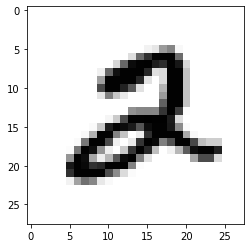

In [90]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")

### Converting the 'y' to `int` type from `str`

In [11]:
y = y.astype(np.uint8)

### Spliting data into 'train' and 'test' sets

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classification
##### For simplicity purpose we can try to identify only one digit(5) and this '5-detector' will be a binary classifier

In [13]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)
y_train_5.head()

0     True
1    False
2    False
3    False
4    False
Name: class, dtype: bool

### Stochastic Gradient Descent(SGD) classifier is capable of handling a very large datasets efficiently because SGD deals with training instances independently, one at a time

In [14]:
from sklearn.linear_model import SGDClassifier


In [15]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

#### Checking the classifier's prediction on 'some_digit'

In [16]:
sgd_clf.predict([some_digit])

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

#### Measuring Accuracy using Cross Validation method `cross_val_score()`
In this method K-fold cross-validation will split the training set in 3 folds, then will make predictions and evaluate them on each fold using a model trained on remaining folds.

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### Prediction using a Dumb classifier 

In [19]:
from sklearn.base import BaseEstimator

In [20]:
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### `cross_val_predict` performs K-fold cross-validation just like `cross_val_score` but returns predictions made on each test fold instead of evaluation scores

In [22]:
from sklearn.model_selection import cross_val_predict

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

### Confusion matrix
It provides a much better way to evaluate the performance of a classifier.

**Confusion Matrix Layout**  
|   True -ve    |   False +ve   |  
|   False -ve   |   True +ve    |

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### How a Perfect Confusion Matrix looks like

In [26]:
y_train_perfect_pred = y_train_5

In [27]:
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### Difference between Precision & Recall

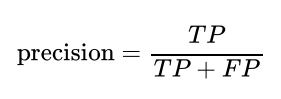


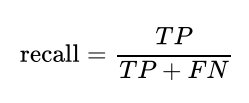  
here, TP-No. of True positives, FP-No. of False positives and TP-No. of False negatives


#### Precision & Recall realtion  
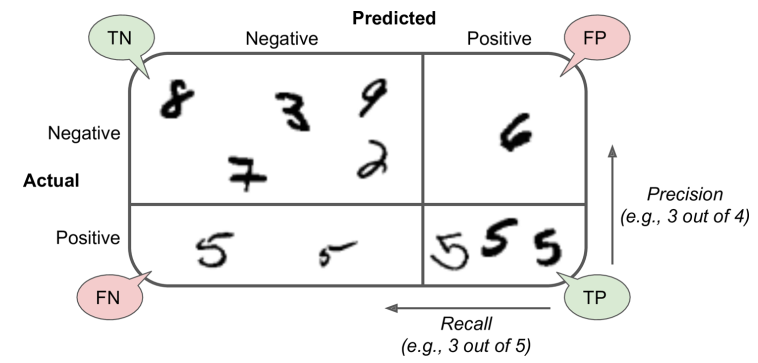  

increasing precision reduces recall, and vice versa and this is called the **Precision/Recall trade-off**

In [28]:
from sklearn.metrics import precision_score, recall_score

In [29]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### **F1 score** is the harmonic mean of precision and recall  
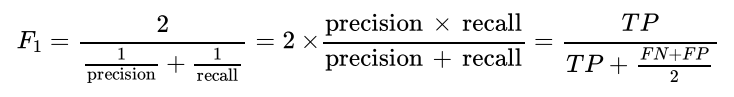

In [31]:
from sklearn.metrics import f1_score

In [32]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### `decision function` depends on the decision threshold of the classifier(here SGDClassifier)
it returns a score for each instance

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([-3908.27576291])

#### SGDClassifier uses a threshold of 0, which is proved by the previous identical results 

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### Now how to decide which threshold value to use

1. using `cross_val_predict()` function to get the scores of all instances in the training set and also specifying that to return decision scores instead of predictions

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [36]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

2. using `precision_recall_curve()` function to compute precision and recall for all possible thresholds

In [37]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

3. using `matplotlib` to plot precision and recall as functions of the threshold value

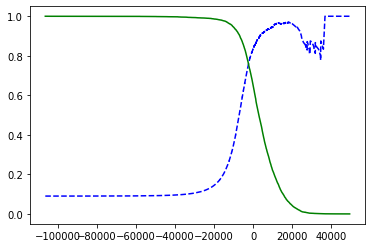

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

4. alternatively, plotting precision directly against recall to select a good precision/recall trade-off

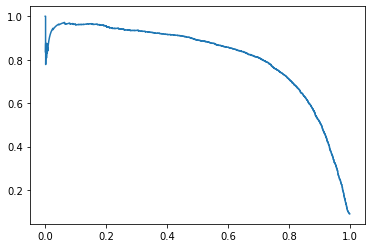

In [39]:
plt.plot(recalls, precisions)

#### `np.argmax()` function searchs for the lowest threshold that gives at least 90% precision  
*  will give the first index of the maximum value, which in this case means the first True value

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
threshold_90_precision

3370.019499143957

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

#### Receiver Operating Characteristics(ROC) curve
* used to plot recall/true positive rate(tpr) against false positive rate(fpr)
* fpr = 1 - true negative rate/specificity(tnr)

In [44]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot()

* a good classifier stays as far away from that dotted line as possible (toward the top-left corner)

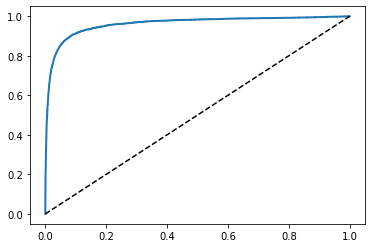

In [46]:
plot_roc_curve(fpr, tpr)

#### Area under ROC
*  perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### **RandomForestClassifier's** ROC curve and ROC AUC score against **SGDClassifier**

In [48]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

#### RandomForestClassifier has `predict_proba()` function instead of `decision_function()`

In [49]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

#### ROC curve is fed with probabilities in place of labels & scores

In [50]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

#### RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s

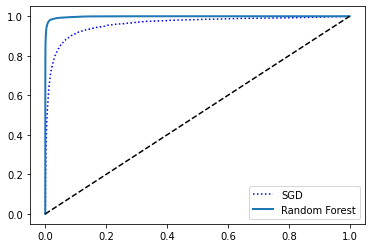

In [51]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

#### ROC AUC score, Precision score & Recall score are all impressive for RandomForestClassifier

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [53]:
y_train_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [54]:
precision_score(y_train_5, y_train_forest)

0.9905083315756169

In [55]:
recall_score(y_train_5, y_train_forest)

0.8662608374838591

## Multiclass Classification

### Support Vector Machine classifier

In [56]:
from sklearn.svm import SVC
svm_clf = SVC()

In [57]:
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([2], dtype=uint8)

#### The highest score is high for the some_digit value which is 2
It returns 10 scores per instance as in one-versus-one strategy instead of just 1 as in one-versus-rest strategy, which means one score per class.

In [58]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 2.7442516 , -0.30125634,  9.31399134,  7.26965016,  3.75753908,
         3.74771902,  0.71155138,  2.76650678,  8.2765048 ,  6.21840456]])

In [59]:
np.argmax(some_digit_scores)

2

In [60]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

* A trained classifier stores the list of target classes in its `classes_` attribute, ordered by value.
* In this case, the index of each class in the `classes_` array conveniently matches the class itself

In [61]:
svm_clf.classes_[3]

3

### Forcing sklearn to use one-versus-rest strategy for SVM classifier

In [62]:
#from sklearn.multiclass import OneVsRestClassifier
#ovr_clf = OneVsRestClassifier(SVC())

In [63]:
#ovr_clf.fit(X_train, y_train)
#ovr_clf.predict([some_digit])

#### Similarly training SGD Classifier

In [64]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2], dtype=uint8)

#### Evaluating the classifier by cross validation

In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

### Scaling the inputs using Standard Scaler

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [67]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error analysis using confusion matrix

In [68]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

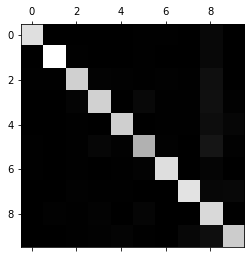

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

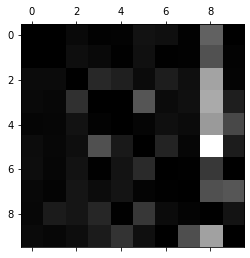

In [71]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

# Multilabel Classification
* a classification system that outputs multiple binary tags
* using KNN which supports multilabel classification

In [72]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

#### Creating multilabels  for each digit image to classify whether or not it's large(7,8 or 9) & whether or not it's odd

In [73]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [74]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

* it correctly predict that 'some_digit' is not large & not odd

In [75]:
knn_clf.predict([some_digit])

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False, False]])

#### Evaluating the multilabel classifier using F1 score

In [76]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

* This `f1_score` assumes that all labels are equally important as average="macro"
* To get weighted scoring based on the number of instances of each label, set average="weighted"

In [77]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification  
* It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values)

### Adding noise to the training & test sets from MNIST images using numpy's `randint()` function

In [78]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

#### Noisey data vs Unnoisey data

In [82]:
X_train_mod.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,65.0,11.0,65.0,30.0,17.0,45.0,42.0,3.0,94.0,0.0,...,80.0,59.0,45.0,53.0,81.0,12.0,31.0,36.0,26.0,51.0
1,24.0,22.0,8.0,28.0,31.0,80.0,77.0,9.0,13.0,75.0,...,67.0,30.0,81.0,87.0,73.0,95.0,62.0,72.0,99.0,74.0
2,49.0,57.0,26.0,35.0,31.0,96.0,48.0,87.0,40.0,12.0,...,13.0,51.0,41.0,75.0,43.0,17.0,26.0,72.0,13.0,3.0
3,67.0,1.0,24.0,88.0,55.0,81.0,39.0,77.0,20.0,75.0,...,80.0,2.0,29.0,18.0,43.0,49.0,5.0,25.0,59.0,68.0
4,88.0,34.0,53.0,30.0,91.0,91.0,67.0,49.0,41.0,95.0,...,69.0,39.0,11.0,30.0,64.0,74.0,39.0,91.0,35.0,74.0


In [83]:
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Visualizing the noise level

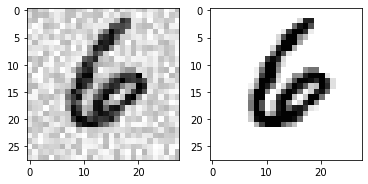

In [103]:
def viz_noise(n):
    train_list = [X_train_mod, X_train]
    fig, ax = plt.subplots(1, 2)
    for i,train in enumerate(train_list):
        test_digit = train.iloc[n]
        test_digit_image = test_digit.values.reshape(28, 28)
        ax[i].imshow(test_digit_image, cmap="binary")

viz_noise(13)

#### Training the classifier to clean noisy image

In [96]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

#### Feeding noisy 'X' data

In [128]:
clean_digit = knn_clf.predict([X_test_mod.iloc[3]])

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


#### Getting clean digit image 

In [131]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = "binary", interpolation="nearest")
    plt.axis("off")

#plot_digit(X_test_mod.iloc[3])

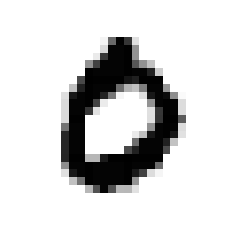

In [126]:
plot_digit(X_test.iloc[3])

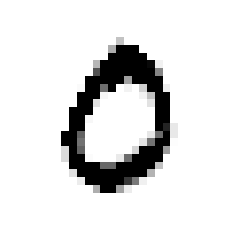

In [132]:
plot_digit(clean_digit)

C:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


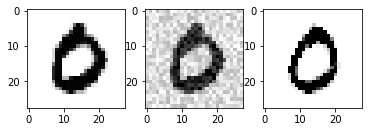

In [142]:
def viz_clean(n):
    test_list = [X_test, X_test_mod, X_test_mod]   
    fig, ax = plt.subplots(1, 3)
    for i,test in enumerate(test_list):
        if i < 2:
            digit_data = test.iloc[n]
            digit_image = digit_data.values.reshape(28, 28)
        else:
            digit_data = knn_clf.predict([test.iloc[n]])
            digit_image = digit_data.reshape(28, 28)
        ax[i].imshow(digit_image, cmap="binary")


viz_clean(3)

# Extra from the [book's](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) github link

In [143]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

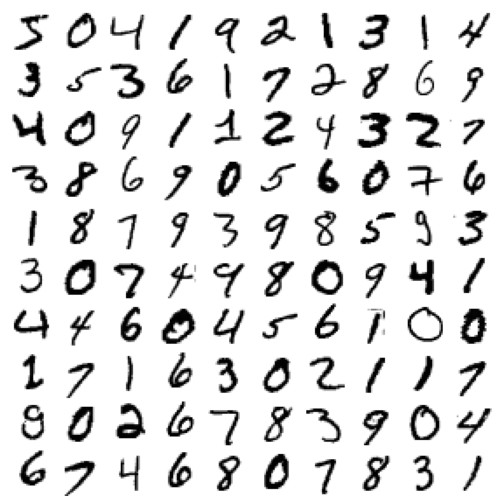

In [144]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)